# Hot Hand Modeling Techniques
## CS109a Final Project
** Tommy, Kyle, Toni, Chip ** 11/24/16

In [1]:
## Load necessary libraries
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

** Description of work within: **

- Load in dataset with proper features
    - Generate previous streak variable
    - Encode other variables as needed
        - Maybe we should add in other player and defender fixed-effects in the future


- Implement baseline model: logit reg of indicator for making shot on streak metric
    - Run this regression for whole dataset
    - Graph logistic function y versus x


- Improve baseline model by adding confounding variables
    - Compare p-values of predictors
    - Interpret Coefficients
    - Compare previous models versus one restricting streak metric to be non-negative
    
    
- Implement robust model for specific players
    - Import top 20 players from previous work
    - Top 20 players selected by generating a score that balances high shot variance and number of shots per game. We want to look at frequen shooters from all over the floor, not just big men or 3-point specialists

In [2]:
## Load in dataset with proper features

# Read in data
data = pd.read_csv('datasets/Augmented_Dataset.csv', index_col=0)
data.columns = map(str.lower, data.columns)

# Generate previous_streak variable
data['previous_streak'] = data.groupby(['player_id', 'game_id'])['current_streak'].apply(lambda x: x.shift(1).fillna(0)).astype(int)

# Preview data
print 'Number of variables:', np.shape(data)[1]
print 'Variable names:', data.columns.values
print 'Number of observations/shots:', np.shape(data)[0]
data.head()

Number of variables: 24
Variable names: ['game_id' 'matchup' 'location' 'w' 'final_margin' 'shot_number' 'period'
 'game_clock' 'shot_clock' 'dribbles' 'touch_time' 'shot_dist' 'pts_type'
 'shot_result' 'closest_defender' 'closest_defender_player_id'
 'close_def_dist' 'fgm' 'pts' 'player_name' 'player_id' 'fg_percent'
 'current_streak' 'previous_streak']
Number of observations/shots: 118033


,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id,fg_percent,current_streak,previous_streak
28621,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,1,1,2:29,22.1,0,...,"Roberts, Brian",203148,4.4,1,3,ryan anderson,201583,0.407407,1,0
28622,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,2,2,11:19,5.8,2,...,"Zeller, Cody",203469,6.1,1,2,ryan anderson,201583,0.407407,2,1
28623,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,3,2,10:51,10.2,2,...,"Maxiell, Jason",101131,5.7,0,0,ryan anderson,201583,0.407407,-1,2
28624,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,4,2,8:21,24.0,0,...,"Zeller, Cody",203469,2.6,1,2,ryan anderson,201583,0.407407,1,-1
28625,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,5,2,7:59,16.0,0,...,"Zeller, Cody",203469,6.5,0,0,ryan anderson,201583,0.407407,-1,1


In [3]:
## Data manipulation/cleaning

# Convert categorical variable into dummy/indicator variables
encoding = pd.get_dummies(data['w'])
data = pd.concat((data, encoding), axis=1)
data.drop('L', axis=1, inplace=True)

# Impute missing 'shot_clock' vals
data['shot_clock'].fillna(0, inplace=True)

## Maybe in future:
    # Make fixed effects for: 'game_id', 'closest_defender_player_id', 'player_id'
    # Encode: 'game_clock'

In [4]:
## Implement baseline model: logit reg of indicator for making shot on streak metric
    # Run this regression for top 20 players
    # Assess model's quality
    
# Split x and y
x = data['previous_streak']
x = x.reshape(-1, 1)
y = data['fgm'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=42)

# Fit model
baseline_logit = LogisticRegression()
baseline_logit.fit(x_train, y_train)

# Print coefficients
coef = baseline_logit.coef_[0][0]
print 'Coefficient on streak predictor:', coef

# Score model
score = baseline_logit.score(x_test, y_test)
print 'Classification rate:', score

Coefficient on streak predictor: -0.00836280125822
Classification rate: 0.546130385055


** Discussion: **

Even without any other predictors the coefficient on the streak predictor is a pretty precisely estimated 0. Furthermore, the model barely performs any better than 50% i.e. the model is not much better than flipping a coin, so in this situation the hot hand theory looks weak.

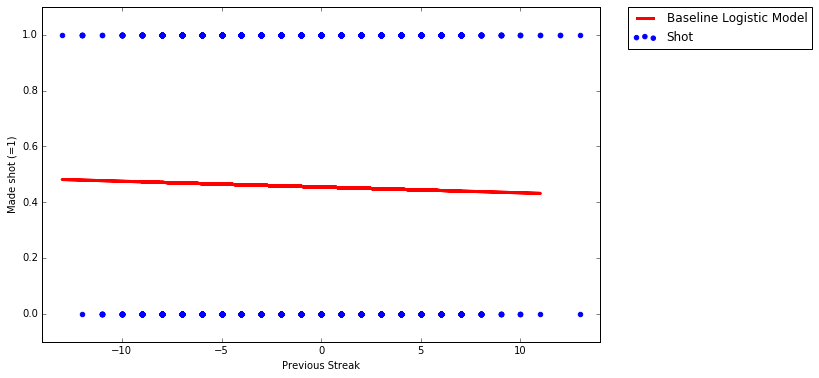

In [5]:
## Graph y as a function of x

# Fit model
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Plot the result
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.scatter(x.ravel(), y, color='blue', zorder=20)
def model(x):
    return 1 / (1 + np.exp(-x))
loss = model(x_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(x_test, loss, color='red', linewidth=3)

plt.ylabel('Made shot (=1)')
plt.xlabel('Previous Streak')
plt.ylim(-0.1, 1.1)
plt.xlim(-14, 14)
plt.legend(('Baseline Logistic Model', 'Shot'),
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Even the graph of the model shows a pretty useless and nondescriminant model.

In [6]:
## Using statsmodels

# Fit the model
logit = sm.Logit(data['fgm'], data['previous_streak'])
result = logit.fit()

# Print results
result.summary()

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    fgm   No. Observations:               118033
Model:                          Logit   Df Residuals:                   118032
Method:                           MLE   Df Model:                            0
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:               -0.005983
Time:                        17:31:42   Log-Likelihood:                -81814.
converged:                       True   LL-Null:                       -81328.
                                        LLR p-value:                       nan
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
previous_streak     0.0009      0.003      0.319      0.750        -0.005     0.007
===================================================================================
"""

** Wow. ** P-value is huge and standard error is huge relative to the actual estimate of the coefficient. Seems pretty unlikely that the previous_streak variable is going to have much prediction power.

In [7]:
## Checking for confounding variables
    # One by one, add in what you believe could be confounding variables 
    # and see if the ‘streak’ metric turns/still is significant.

# Create array of possible confounders
possible_confounders = ['previous_streak', 'final_margin', 'dribbles', 'touch_time', 'shot_dist', 'close_def_dist', 
                        'fg_percent', 'shot_clock']

# Choose x_set
x = data[possible_confounders]
y = data['fgm'].values

# Look at results
logit = sm.Logit(y, x)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.659334
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               118033
Model:                          Logit   Df Residuals:                   118025
Method:                           MLE   Df Model:                            7
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:                 0.04309
Time:                        17:31:42   Log-Likelihood:                -77823.
converged:                       True   LL-Null:                       -81328.
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
previous_streak    -0.0078      0.003     -2.618      0.009        -0.014    -0.002
final_margin        0.0093      0.000     20.178      0.000         0.008     0.010
dribbles            0.0246      0.005      5.226      0.000         0.015     0.034
touch_time         -0.0565      0.005    -10.306      0.000        -0.067    -0.046
shot_dist          -0.0600      0.001    -71.926      0.000        -0.062    -0.058
close_def_dist      0.1000      0.003     35.055      0.000         0.094     0.106
fg_percent          0.3260      0.041      7.964      0.000         0.246     0.406
shot_clock          0.0147      0.001     14.809      0.000         0.013     0.017
===================================================================================
"""

In [8]:
## Score model

# Split robust predictors
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=42)

# Fit model
robust_logit = LogisticRegression(C=100000000.0)
robust_logit.fit(x_train, y_train)

# Score and print
score = robust_logit.score(x_test, y_test)
print 'Classification rate:', score

Classification rate: 0.608061168298


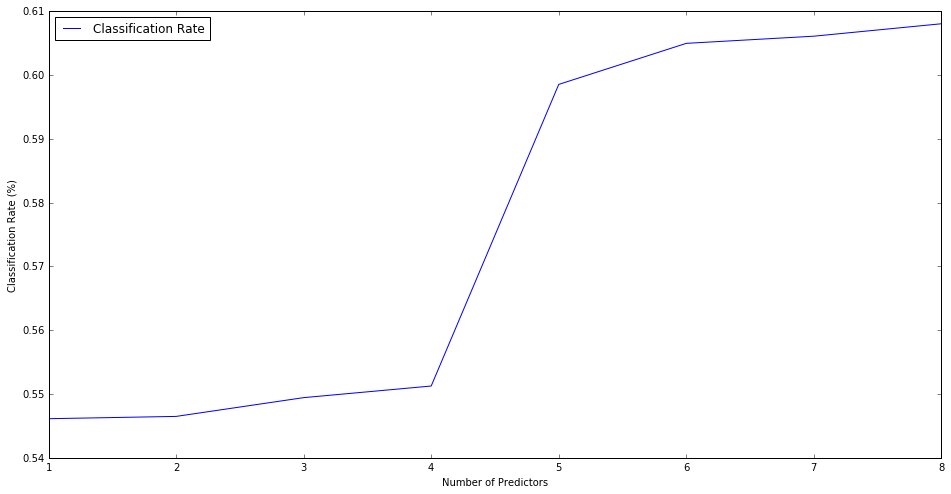

['previous_streak', 'final_margin', 'dribbles', 'touch_time', 'shot_dist', 'close_def_dist', 'fg_percent', 'shot_clock']


In [59]:
## Create graph that shows increasing classification rate as # of factors increases

# Create array of possible confounders
possible_confounders = ['previous_streak', 'final_margin', 'dribbles', 'touch_time', 'shot_dist', 'close_def_dist', 
                        'fg_percent', 'shot_clock']

# Choose x_set
x = data[possible_confounders]
y = data['fgm'].values

# Look at results
logit = sm.Logit(y, x)
result = logit.fit(disp=0)
result.summary()

# declare plot arrays
numbers = []
rates = []

# Loop through confounders and add one by one and output number of predictors and accuracy
for i in range(len(possible_confounders)):
    
    # Grab predictors
    confounders = possible_confounders[:i+1]
    
    # Set number of predictors
    num_confounders = len(confounders)
    
    # Set x
    x = data[confounders]
    
    # Fit model
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=42)
    robust_logit = LogisticRegression(C=100000000.0)
    robust_logit.fit(x_train, y_train)
    score = robust_logit.score(x_test, y_test)
    numbers.append(num_confounders)
    rates.append(score)
    
# Plot
fig = plt.figure(figsize=(16,8))
# plot both
ax1 = fig.add_subplot(111)
ax1.plot(numbers, rates, 'blue', label='Classification Rate')
#ax1.set_xlim(-7, 8)
ax1.set_xlabel('Number of Predictors'); plt.ylabel('Classification Rate (%)')
ax1.legend(loc='best')
plt.show()

# Print predictors
print confounders

** Important! **

By adding other predictors, the streak variable does become significant, albeit just barely and the sign of the coefficient is the opposite of what we might expect. I.e., the coefficient is a very small negative term indicating that each additional shot made in a streak will decrease the log-likelihood of making the next shot.

In [9]:
## Interpreting coefficient

print 'Coefficient odds ratio and 95% CI:'
print ''
params = result.params
conf = result.conf_int()
conf['Estimated coefficient'] = params
conf.columns = ['2.5%', '97.5%', 'Estimated coefficient']
print np.exp(conf)


Coefficient odds ratio and 95% CI:

                     2.5%     97.5%  Estimated coefficient
previous_streak  0.986372  0.998030               0.992184
final_margin     1.008435  1.010260               1.009347
dribbles         1.015508  1.034437               1.024929
touch_time       0.934945  0.955262               0.945049
shot_dist        0.940182  0.943264               0.941722
close_def_dist   1.099009  1.111367               1.105171
fg_percent       1.278573  1.501069               1.385361
shot_clock       1.012806  1.016746               1.014774


** Interpreting coefficients **

The above shows us that the exponential of the produced coefficients from the logistic regression. This tells us how a 1 unit increase in a variable affects the odds of making the shot.

So for the above, an increase in one's streak by one shot, actually decreases the odds of making the next shot by less than 1 percent. This is *such* a small effect. It is, again, actually impressive how small of an effect this is.

In [10]:
## Only positive streaks

# Restrict data set to where previous_streak>=0
positive_streak_data = data[data['previous_streak']>=0]

# Only streak metric
y = positive_streak_data['fgm'].values
x = positive_streak_data['previous_streak']

# Look at results
logit = sm.Logit(y, x)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.689783
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                60242
Model:                          Logit   Df Residuals:                    60241
Method:                           MLE   Df Model:                            0
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:               -0.002912
Time:                        17:31:43   Log-Likelihood:                -41554.
converged:                       True   LL-Null:                       -41433.
                                        LLR p-value:                       nan
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
previous_streak    -0.0929      0.005    -19.993      0.000        -0.102    -0.084
===================================================================================
"""

In [11]:
# Use more robust x
x = positive_streak_data[possible_confounders]

# Look at results
logit = sm.Logit(y, x)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.658520
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                60242
Model:                          Logit   Df Residuals:                    60234
Method:                           MLE   Df Model:                            7
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:                 0.04254
Time:                        17:31:43   Log-Likelihood:                -39671.
converged:                       True   LL-Null:                       -41433.
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
previous_streak    -0.0177      0.007     -2.370      0.018        -0.032    -0.003
final_margin        0.0089      0.001     13.792      0.000         0.008     0.010
dribbles            0.0386      0.007      5.897      0.000         0.026     0.051
touch_time         -0.0713      0.008     -9.304      0.000        -0.086    -0.056
shot_dist          -0.0596      0.001    -51.357      0.000        -0.062    -0.057
close_def_dist      0.0958      0.004     23.870      0.000         0.088     0.104
fg_percent          0.3813      0.060      6.312      0.000         0.263     0.500
shot_clock          0.0155      0.001     10.966      0.000         0.013     0.018
===================================================================================
"""

** Comment: **

Even after restricting to just the positive streaks, the streak metric still has a negative coefficient, and a slightly larger one at that.

In [12]:
## Define function which takes as input player_name, runs logit model on them,
    # prints coef on previous_streak, std err, p-val, and r^2
    
def player_hothand_logit(player_name):
    
    # Get player data
    player_data = data[data['player_name']==player_name]
    
    # Set x and y
    y = player_data['fgm'].values
    x = player_data[possible_confounders]

    # Fit model
    logit = sm.Logit(y, x)
    result = logit.fit(disp=0)
    
    # Return params
    print player_name, '- Individual Hot Hand Effect:'
    print 'Hot Hand Coef:', result.params.previous_streak
    print 'Odds ratio effect:', np.exp(result.params.previous_streak)
    print 'Std Err:', result.bse.previous_streak
    print 'p:', result.pvalues.previous_streak
    print 'Pseudo R^2:', result.prsquared

In [13]:
## For individual players

# Crate player_name_array
player_name_array = data['player_name'].unique()

# Loop through players
for i in range(5):
    # Run model
    player_hothand_logit(player_name_array[i])
    print ''

ryan anderson - Individual Hot Hand Effect:
Hot Hand Coef: 0.0149235980998
Odds ratio effect: 1.01503551101
Std Err: 0.038631107263
p: 0.699266806788
Pseudo R^2: 0.0375141398444

chandler parsons - Individual Hot Hand Effect:
Hot Hand Coef: -0.00827374630692
Odds ratio effect: 0.991760386931
Std Err: 0.0374971638618
p: 0.825365026253
Pseudo R^2: 0.0504197772802

kirk hinrich - Individual Hot Hand Effect:
Hot Hand Coef: -0.0750451921356
Odds ratio effect: 0.927701560566
Std Err: 0.0766734767793
p: 0.327696902175
Pseudo R^2: 0.0685518959432

kentavious caldwell-pope - Individual Hot Hand Effect:
Hot Hand Coef: -0.0254234182048
Odds ratio effect: 0.974897035472
Std Err: 0.0413170021511
p: 0.538339569609
Pseudo R^2: 0.0534000378068

kevin love - Individual Hot Hand Effect:
Hot Hand Coef: 0.0213406260413
Odds ratio effect: 1.02156996571
Std Err: 0.0366219969633
p: 0.560077101257
Pseudo R^2: 0.0384728105759



In [14]:
## Players of note
players_sorted = pd.read_csv('datasets/df_score.csv')
key_players = players_sorted.iloc[:,0].values[:20]

# Loop through players
for player in key_players:
    
    # Run function
    player_hothand_logit(player)
    print ''

lebron james - Individual Hot Hand Effect:
Hot Hand Coef: -0.0537881979139
Odds ratio effect: 0.947632795851
Std Err: 0.0342415196943
p: 0.116218127937
Pseudo R^2: 0.0882355882896

damian lillard - Individual Hot Hand Effect:
Hot Hand Coef: 0.0299570932766
Odds ratio effect: 1.03041032147
Std Err: 0.03112343475
p: 0.335785802213
Pseudo R^2: 0.0549934857086

russell westbrook - Individual Hot Hand Effect:
Hot Hand Coef: -0.0376355519373
Odds ratio effect: 0.9630638637
Std Err: 0.0329074043159
p: 0.252756222297
Pseudo R^2: 0.063785723483

james harden - Individual Hot Hand Effect:
Hot Hand Coef: 0.0260540384177
Odds ratio effect: 1.02639641181
Std Err: 0.0278856511672
p: 0.350140388868
Pseudo R^2: 0.0439483369995

carmelo anthony - Individual Hot Hand Effect:
Hot Hand Coef: -0.0520518407993
Odds ratio effect: 0.949279654151
Std Err: 0.0367973608848
p: 0.157199409519
Pseudo R^2: 0.0425258515741

stephen curry - Individual Hot Hand Effect:
Hot Hand Coef: -0.0750044964831
Odds ratio effect:

## Conclusion: ##

** Streak metric is generally a poor predictor ** or it has very little predictive significance. From our robust model on the whole dataset, the streak metric is significant, but very small in relative magnitude. For an increase in streak of one unit, this only affects the probability of making the next shot by about or less than 1%. Furthermore, this effect on probability is a decrease, i.e. the exact opposite of what we expect to see if the hot hand were true. If anything, a shooter on a streak becomes less likely to make their next shot.

** These results hold true if the data is restricted to observations where the streak metric is non-negative. **

** The hot hand effect varies for our top 20 players. ** If we fit models for individual players, the hot hand effect varies in both magnitude and sign. There is about an equal distribution of negative and positive estimated coefficients which resonates with our finding that the streak metric is generally an estimated zero when the model is run on the whole dataset. Unfortunately, most of these estimates have p-values greater than .05 or .1 indicating that our estimates are not significant. Interestingly enough though is that the only player to have a significant estimate is Steph Curry (likely because he takes a large amount of shots). Steph's hot hand effect is estimated to be a negative coefficient though that implies as Steph makes an additional shot in a streak, his probability of making the next shot decreases by about 8% (which is pretty significant in magnitude). The player with the largest positive hot hand effect is Derrick Rose whose probability of making the next shot increases by about 5% for each additional shot he makes in a streak.

** Comment on next steps: ** These are some pretty interesting results I think. There are a number of ways in which we can move forward. We can try to improve the quality of our model by adding in more predictors. Having a predictor to encapsulate defender quality sticks out to me as the most important one to add. We could also try to analyze what determines who has a high individual hot hand effect. Why does Derek Rose have such a hot hand while Steph only gets colder as he makes more shots? Definitely plenty of cool work left to be done I think. Next steps more concretely discussed in our Milestone 5 Report.


In [22]:
## Export dataset

data.to_csv("datasets/dataset_post_model")